# Project: Stock Price Prediction Model

### Goal:
#### Predict the next day’s closing price of a stock based on historical features:
#### Open, High, Low, Close, Volume

In [11]:
%pip install tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings


Note: you may need to restart the kernel to use updated packages.


In [12]:
# Example: Load from CSV (replace with your file path)

df = pd.read_csv('AAPL.csv')  # Example dataset
print(df.head())


   Unnamed: 0 symbol                       date    close     high     low  \
0           0   AAPL  2015-05-27 00:00:00+00:00  132.045  132.260  130.05   
1           1   AAPL  2015-05-28 00:00:00+00:00  131.780  131.950  131.10   
2           2   AAPL  2015-05-29 00:00:00+00:00  130.280  131.450  129.90   
3           3   AAPL  2015-06-01 00:00:00+00:00  130.535  131.390  130.05   
4           4   AAPL  2015-06-02 00:00:00+00:00  129.960  130.655  129.32   

     open    volume    adjClose     adjHigh      adjLow     adjOpen  \
0  130.34  45833246  121.682558  121.880685  119.844118  120.111360   
1  131.86  30733309  121.438354  121.595013  120.811718  121.512076   
2  131.23  50884452  120.056069  121.134251  119.705890  120.931516   
3  131.20  32112797  120.291057  121.078960  119.844118  120.903870   
4  129.86  33667627  119.761181  120.401640  119.171406  119.669029   

   adjVolume  divCash  splitFactor  
0   45833246      0.0          1.0  
1   30733309      0.0          1.0  

In [13]:
# Ensure the date column is datetime

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)


In [14]:
print(df.isnull().sum())


Unnamed: 0     0
symbol         0
close          0
high           0
low            0
open           0
volume         0
adjClose       0
adjHigh        0
adjLow         0
adjOpen        0
adjVolume      0
divCash        0
splitFactor    0
dtype: int64


In [15]:
# Feature Selection

data = df[['open', 'high', 'low', 'close', 'volume']]
data


open     high       low    close    volume
date                                                                   
2015-05-27 00:00:00+00:00  130.34  132.260  130.0500  132.045  45833246
2015-05-28 00:00:00+00:00  131.86  131.950  131.1000  131.780  30733309
2015-05-29 00:00:00+00:00  131.23  131.450  129.9000  130.280  50884452
2015-06-01 00:00:00+00:00  131.20  131.390  130.0500  130.535  32112797
2015-06-02 00:00:00+00:00  129.86  130.655  129.3200  129.960  33667627
...                           ...      ...       ...      ...       ...
2020-05-18 00:00:00+00:00  313.17  316.500  310.3241  314.960  33843125
2020-05-19 00:00:00+00:00  315.03  318.520  313.0100  313.140  25432385
2020-05-20 00:00:00+00:00  316.68  319.520  316.2000  319.230  27876215
2020-05-21 00:00:00+00:00  318.66  320.890  315.8700  316.850  25672211
2020-05-22 00:00:00+00:00  315.77  319.230  315.3500  318.890  20450754

[1258 rows x 5 columns]

In [16]:
# Feature Scaling

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [17]:
# Sequences for Time-Series Prediction

X, y = [], []
sequence_length = 60

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])  # last 60 days
    y.append(scaled_data[i, 3])  # next day's close (index 3)

X, y = np.array(X), np.array(y)


In [18]:
# Split Data into Train/Test Sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [19]:
# Build the LSTM Model

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


c:\Users\geeze\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,701 (127.74 KB)

 Trainable params: 32,701 (127.74 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Training the Model

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - loss: 0.0130 - val_loss: 0.0011
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 9.2024e-04 - val_loss: 0.0011
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 9.8695e-04 - val_loss: 0.0024
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step -

In [21]:
# Evaluate the Model

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.6f}')
print(f'R² Score: {r2:.4f}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
MSE: 0.006283
R² Score: 0.7938


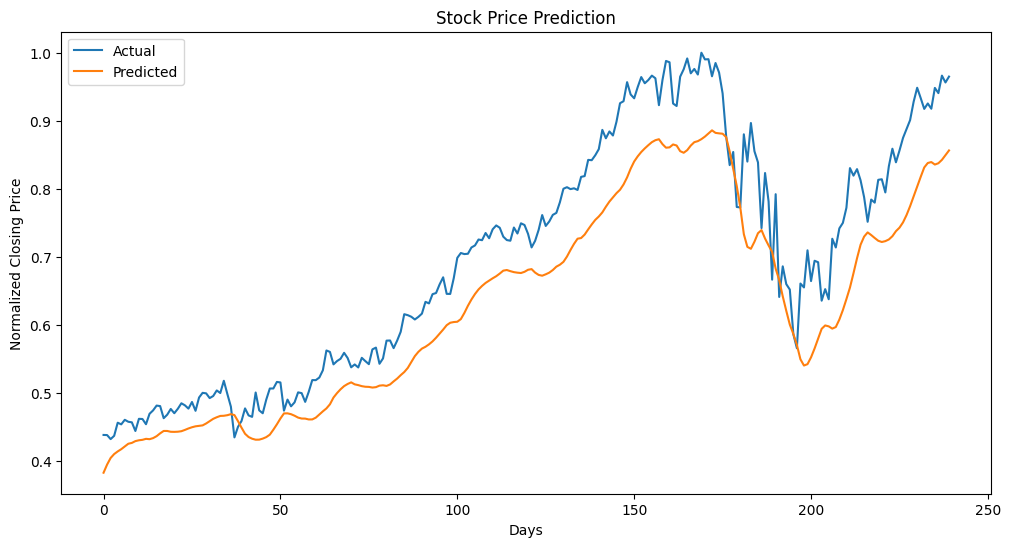

In [22]:
# Visualize Predictions

plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Normalized Closing Price')
plt.legend()
plt.show()


In [23]:
# Predict Future Stock Prices

last_60_days = scaled_data[-60:]
future_input = np.array([last_60_days])
future_pred = model.predict(future_input)
predicted_price = scaler.inverse_transform(
    np.concatenate((np.zeros((1,3)), [[future_pred[0][0]]], np.zeros((1,1))), axis=1)
)[0,3]
print(f"Predicted next day closing price: {predicted_price}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted next day closing price: 294.57621278405185


### What I have done in this project/ Summary

| Step | Task                | Description                    |
| ---- | ------------------- | ------------------------------ |
| 1    | Load Data           | Import and clean stock data    |
| 2    | Feature Engineering | Create lag-based sequences     |
| 3    | Model               | LSTM Neural Network            |
| 4    | Evaluation          | MSE, R², Plot predictions      |
| 5    | Future Prediction   | Predict next-day closing price |


### model building:

Data → Preprocessing → Model → Training → Evaluation → Prediction